# Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load Dataset
d = pd.read_csv("C:\\Users\\patte\\Downloads\\Project.zip")
df = pd.DataFrame(d)

In [6]:
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [10]:
# Convert Data Column
df['Effective To Date'] = pd.to_datetime(df['Effective To Date'])

In [12]:
# Feature Engineering
snapshot_date = df['Effective To Date'].max()
df['Recency'] = (snapshot_date - df['Effective To Date']).dt.days
df['Frequency'] = df['Number of Policies']
df['AOV'] = df['Total Claim Amount'] / df['Number of Policies'].replace(0, 1)

In [14]:
# Encode categorical variables
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [16]:
# Features and Target
features = ['Income', 'Monthly Premium Auto', 'Months Since Last Claim',
            'Months Since Policy Inception', 'Number of Open Complaints',
            'Number of Policies', 'Total Claim Amount', 'Recency', 'Frequency', 'AOV']
target = 'Customer Lifetime Value'

X = df[features]
y = df[target]

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Train model using Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [22]:
# Predictions
y_pred = model.predict(X_test)

# Evaluation

In [27]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 1472.09
RMSE: 4032.64


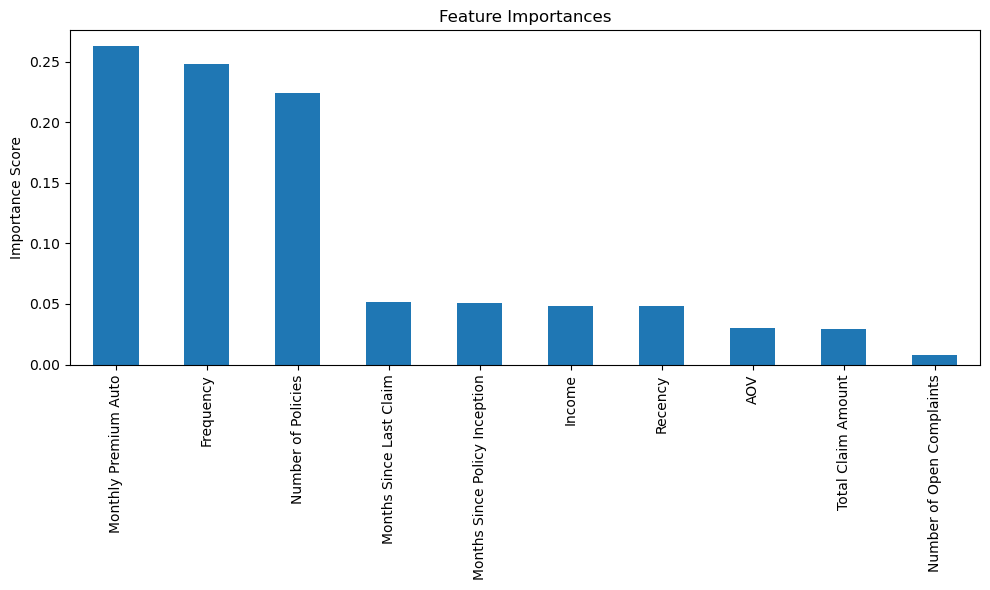

In [29]:
# Feature importance
importances = model.feature_importances_
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)
plt.figure(figsize=(10,6))
feat_importance.plot(kind='bar', title='Feature Importances')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

In [31]:
# Predict on full dataset for segmentation
df['Predicted LTV'] = model.predict(df[features])

In [33]:
# Segment customers
quantiles = df['Predicted LTV'].quantile([0.25, 0.75]).values
def segment(value):
    if value <= quantiles[0]:
        return 'Low'
    elif value <= quantiles[1]:
        return 'Medium'
    else:
        return 'High'
df['LTV Segment'] = df['Predicted LTV'].apply(segment)

# Save Predictions

In [39]:
df[['Customer', 'Predicted LTV', 'LTV Segment']].to_csv("LTV_Predictions_RF.csv", index=False)

# Visualizations

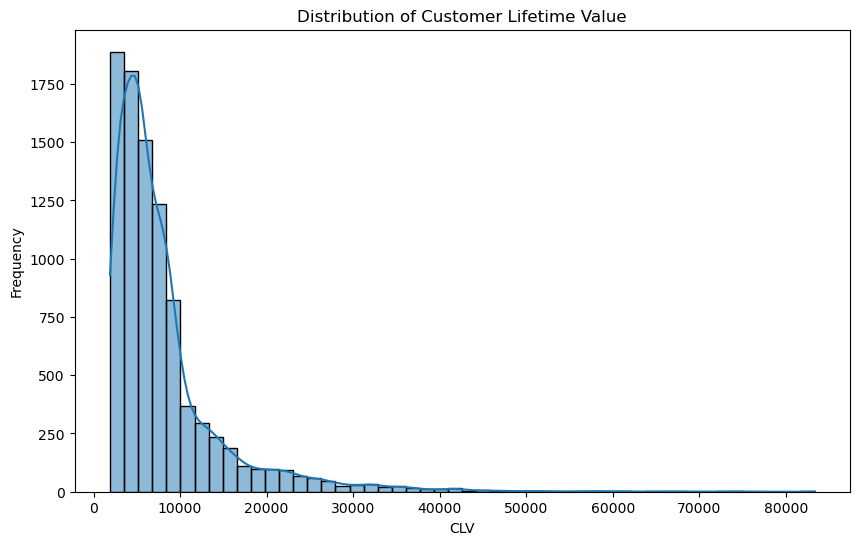

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Customer Lifetime Value'], bins=50, kde=True)
plt.title('Distribution of Customer Lifetime Value')
plt.xlabel('CLV')
plt.ylabel('Frequency')
plt.show()

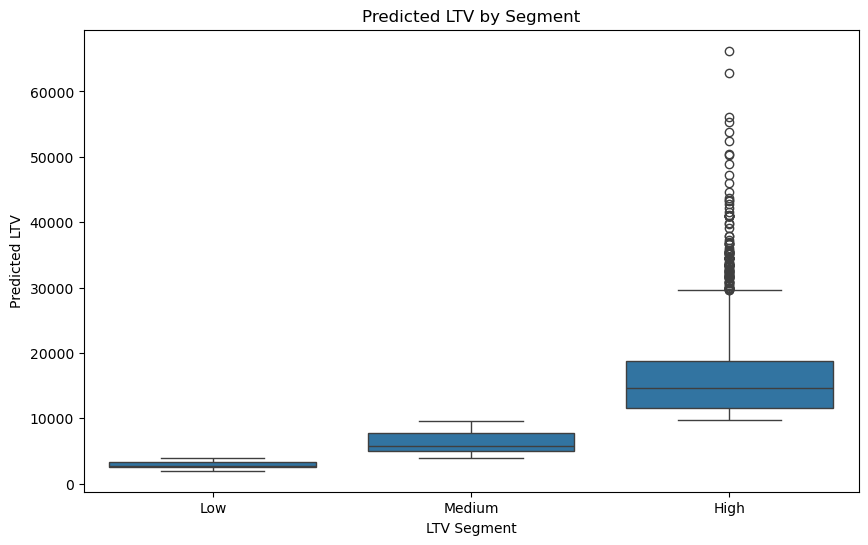

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='LTV Segment', y='Predicted LTV', data=df)
plt.title('Predicted LTV by Segment')
plt.show()

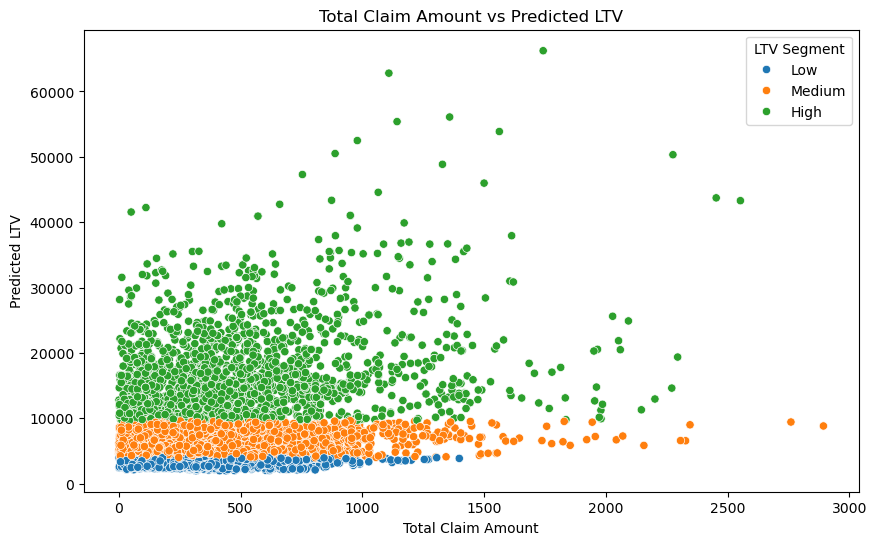

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total Claim Amount', y='Predicted LTV', hue='LTV Segment', data=df)
plt.title('Total Claim Amount vs Predicted LTV')
plt.show()